# SPARCLCLIENT

In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20231103' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial', 'client', 'sparcl', 'NOIRlab']

This notebook demonstrates using the `sparclclient` package to get metadata and spectra data from the ....

## Table of contents
* [Goals & Summary](#goalssummary)
* [Imports and setup](#imports)
* [Discover Images](#discover)
* [Get HDU](#gethdu)
* [Get cutout of object](#cutout)
* [Generate photo album](#album)
* [Find all Messier objects](#messier)
* [Save Messier snapshots](#save_album)

<a class="anchor" id="goals"></a>
## Goals & Summary 
Demonstrate the use of the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/). 
- Discovery: Search for matching metadata and return metadata records.
- Find images containing regions of sky (SIA)
- Retrieve images
  + Full FITS file
  + Single HDU of FITS file
  + Cutout of rectangular region of one HDU of a FITS file (as a new FITS file)


<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
import os.path
from importlib import reload
from collections import defaultdict
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Suppress astropy warnings such as:
# WARNING: The following header keyword is invalid or follows an unrecognized ...
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# %matplotlib inline
# requires installing ipympl
%matplotlib widget
plt.rcParams['font.size'] = 14

<a class="anchor" id="install"></a>
## Install the most recent version of the `sparclclient`:
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
! pip install sparclclient==1.2.1.dev2      # A specific version 
#!pip install -upgrade sparclclient         # Latest released version
#!pip install --pre -upgrade sparclclient   # Lastest pre-released version

# Uncomment next line to load ASTROGET from local current version of software.
#! pip install --pre --upgrade ../..

In [4]:
import sparcl.client
print(f'Run started: {str(datetime.now())}')

Run started: 2023-11-05 19:16:24.677061


<a class="anchor" id="prepare"></a>
# Prepare to use SPARCLCLIENT

In [5]:
server='https://sparc1.datalab.noirlab.edu'  
help(sparcl.client.SparclClient)
client = sparcl.client.SparclClient(url=server, show_curl=True)
client

Help on class SparclClient in module sparcl.client:

class SparclClient(builtins.object)
 |  SparclClient(*, email=None, password=None, url='https://astrosparcl.datalab.noirlab.edu', verbose=False, show_curl=False, connect_timeout=1.1, read_timeout=5400)
 |  
 |  Provides interface to SPARCL Server.
 |  When using this to report a bug, set verbose to True. Also print
 |  your instance of this.  The results will include important info
 |  about the Client and Server that is usefule to Developers.
 |  
 |  Args:
 |      url (:obj:`str`, optional): Base URL of SPARC Server. Defaults
 |          to 'https://astrosparcl.datalab.noirlab.edu'.
 |  
 |      verbose (:obj:`bool`, optional): Default verbosity is set to
 |          False for all client methods.
 |  
 |      connect_timeout (:obj:`float`, optional): Number of seconds to
 |          wait to establish connection with server. Defaults to
 |          1.1.
 |  
 |      read_timeout (:obj:`float`, optional): Number of seconds to
 |     

(sparclclient:1.2.1.dev2, api:11.0, https://sparc1.datalab.noirlab.edu/sparc, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

<a class="anchor" id="info"></a>
# Info

<a class="anchor" id="datasets"></a>
## Data sets available in SPARCL
List all currently available data sets from the server/url associated with client

In [6]:
client.all_datasets

{'BOSS-DR16', 'DESI-EDR', 'SDSS-DR16', 'SDSS-DR17'}

<a class="anchor" id="defaultfieldnames"></a>
## Get default field names
Gets fields tagged as 'default' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'default' fields across all datasets currently available in the SPARC database. The following example of this function produces the same output as it would with no `dataset_list` argument because we currently only have SDSS-DR16 and BOSS-DR16 records in the SPARC database.

In [7]:
client.get_default_fields?

Signature: client.get_default_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'default' that are in DATASET_LIST.
These are the fields used for the DEFAULT value of the include
parameter of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get the default fields. Defaults to None, which
        will return the intersection of default fields in all
        data sets hosted on the SPARC database.

Returns:
    List of fields tagged as 'default' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_default_fields()
    ['dec', 'flux', 'ra', 'sparcl_id', 'specid', 'wavelength']
File:      ~/sandbox/sparclclient/venv/lib/python3.10/site-packages/sparcl/client.py
Type:      method

In [8]:
client.get_default_fields(dataset_list=['SDSS-DR16', 'BOSS-DR16'])

['dec', 'flux', 'ra', 'sparcl_id', 'specid', 'wavelength']

<a class="anchor" id="allfieldnames"></a>
## Get all field names
Gets fields tagged as 'all' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'all' fields across all datasets currently available in the SPARC database.  The following example of this function produces the same output as it would with no `dataset_list` argument because we currently only have SDSS-DR16 and BOSS-DR16 records in the SPARC database.

In [9]:
client.get_all_fields?

Signature: client.get_all_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'all' that are in DATASET_LIST.
These are the fields used for the ALL value of the include parameter
of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get all fields. Defaults to None, which
        will return the intersection of all fields in all
        data sets hosted on the SPARC database.

Returns:
    List of fields tagged as 'all' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_all_fields()
    ['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'survey', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']
File:      ~/sandbox/sparclclient/venv/lib/python3.10/site-packages/sparcl/client.py
Type

In [10]:
print(sorted(client.get_all_fields(dataset_list=['SDSS-DR16', 'BOSS-DR16'])))

['ancillary_target1', 'ancillary_target2', 'anyandmask', 'anyormask', 'bluefiber', 'boss_specobj_id', 'boss_target1', 'boss_target2', 'calibflux', 'calibflux_ivar', 'chi68p', 'chunk', 'class_noqso', 'class_person', 'comments_person', 'cx', 'cy', 'cz', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deredsn2', 'designid', 'dof', 'eboss_target0', 'eboss_target1', 'eboss_target2', 'eboss_target_id', 'elodie_bv', 'elodie_dof', 'elodie_feh', 'elodie_filename', 'elodie_logg', 'elodie_object', 'elodie_rchi2', 'elodie_sptype', 'elodie_teff', 'elodie_z', 'elodie_z_err', 'elodie_z_modelerr', 'exptime', 'fiberid', 'firstrelease', 'flux', 'fluxobjid', 'fracnsighi', 'fracnsiglo', 'fracnsigma', 'instrument', 'ivar', 'lambda_eff', 'legacy_target1', 'legacy_target2', 'marvels_target1', 'marvels_target2', 'mask', 'mjd', 'model', 'npoly', 'nspecobs', 'nturnoff', 'objid', 'plate', 'plateid', 'platequality', 'platerun', 'platesn2', 'primtarget', 'programname', 'ra', 'rchi2', 'rchi2dif

## Version of Server API used by this client

In [11]:
client.version

11.0

<a class="anchor" id="get"></a>
# Get Metadata and Spectra

<a class="anchor" id="find"></a>
## Get Metadata: `client.find`

The first way you can discover your data is by using SPARCL's `client.find()` method, which allows you to find records in the SPARCL database based on certain parameters passed to the function. Only Core fields may be in the `outfields` and `constraints` parameters. The descriptions for all fields, including Core fields, is located [here](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/). The SPARCL Core fields constraint types are:


| Field name       | Constraint type | Example |
|:----------------|:---------------|:-------|
| id               | List of values (but not<br>intended for data discovery) | ['00001658-460c-4da1-987d-e493d8c9b89b',<br>'000017b6-56a2-4f87-8828-3a3409ba1083']
| specid           | List of values | [6988698046080241664, 6971782884823945216]
| targetid         | List of values | [1237679502171374316, 1237678619584692841]
| data_release     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['BOSS-DR16', 'SDSS-DR16']
| datasetgroup     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['SDSS_BOSS']
| ra               | Range of values (may not<br>"wrap" around RA=0) | [44.53, 47.96]
| dec              | Range of values | [2.03, 7.76]
| redshift         | Range of values | [0.5, 0.9]
| redshift_err     | Range of values | [0.000225, 0.000516]
| redshift_warning | List of values  | [0, 3, 5]
| spectype         | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['GALAXY', 'STAR']
| instrument       | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['SDSS', 'BOSS']
| telescope        | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['sloan25m']
| site             | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) |  ['apo']
| specprimary      | List of values (but typically<br>would only include 1 if<br>being used for data<br>discovery constraints) | [1]
| wavemin          | Range of values | [3607, 3608]
| wavemax          | Range of values | [10363, 10364]
| dateobs_center   | Range of values | ['2013-03-14T10:16:17Z',<br>'2014-05-24T12:10:00Z']
| exptime          | Range of values | [3603.46, 3810.12]
| updated          | Range of values | ['2022-08-20T21:37:50.636363Z',<br>'2022-09-20T20:00:00.000000Z']


In [12]:
client.find?

Signature:
client.find(
    outfields=None,
    *,
    constraints={},
    limit=500,
    sort=None,
    verbose=None,
)
Docstring:
Find records in the SPARC database.

Args:
    outfields (:obj:`list`, optional): List of fields to return.
        Only CORE fields may be passed to this parameter.
        Defaults to None, which will return only the sparcl_id
        and _dr fields.

    constraints (:obj:`dict`, optional): Key-Value pairs of
        constraints to place on the record selection. The Key
        part of the Key-Value pair is the field name and the
        Value part of the Key-Value pair is a list of values.
        Defaults to no constraints. This will return all records in the
        database subject to restrictions imposed by the ``limit``
        parameter.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500.

    sort (:obj:`list`, optional): Comma separated list of fields
        to sort by. Defaults to None. (no sorting

#### Define the fields we want returned (`outfields`) and the constraints (`constraints`):

In [13]:
out = ['sparcl_id','specid', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err']
cons = {'spectype': ['GALAXY'],
        'redshift': [0.5, 0.9],
        'data_release': ['BOSS-DR16', 'SDSS-DR16']}

#### Execute the `client.find()` method with our parameters:
The `limit` argument here is being used for demonstration purposes only, and simply returns only the first 20 results here.

In [14]:
found = client.find(outfields=out, constraints=cons, limit=20)

curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "specid", "ra", "dec", "redshift", "spectype", "data_release", "redshift_err"], "search": [["spectype", "GALAXY"], ["redshift", 0.5, 0.9], ["data_release", "BOSS-DR16", "SDSS-DR16"]]}' 'https://sparc1.datalab.noirlab.edu/sparc/find/?limit=20' | python3 -m json.tool


In [15]:
pd.DataFrame.from_records(found.records)

,redshift_err,sparcl_id,data_release,redshift,specid,dec,spectype,ra,_dr
0,0.000241,559c7b68-75d8-11ee-a90d-525400aad0aa,BOSS-DR16,0.675723,-6444647351317147648,28.038851,GALAXY,134.10755,BOSS-DR16
1,0.000242,55d7d47d-75d8-11ee-ba50-525400aad0aa,BOSS-DR16,0.782685,-6444646251805519872,28.084685,GALAXY,134.23727,BOSS-DR16
2,0.000424,565fd69e-75d8-11ee-b584-525400aad0aa,BOSS-DR16,0.797439,-6444643503026450432,28.226386,GALAXY,133.98095,BOSS-DR16
3,0.000238,56cd210b-75d8-11ee-b3b9-525400aad0aa,BOSS-DR16,0.647712,-6444641304003194880,28.429551,GALAXY,134.54531,BOSS-DR16
4,0.000274,56e8876a-75d8-11ee-a38d-525400aad0aa,BOSS-DR16,0.886086,-6444640754247380992,28.452505,GALAXY,134.46525,BOSS-DR16
5,0.000311,57032782-75d8-11ee-b0e2-525400aad0aa,BOSS-DR16,0.898559,-6444640204491567104,28.450988,GALAXY,134.43695,BOSS-DR16
6,0.000315,571ee9b7-75d8-11ee-86ec-525400aad0aa,BOSS-DR16,0.566015,-6444639654735753216,27.305313,GALAXY,133.95386,BOSS-DR16
7,0.000412,573c5312-75d8-11ee-a6a5-525400aad0aa,BOSS-DR16,0.599517,-6444639104979939328,27.381025,GALAXY,134.05133,BOSS-DR16
8,0.000338,575ba44a-75d8-11ee-8ea2-525400aad0aa,BOSS-DR16,0.812179,-6444638555224125440,27.333753,GALAXY,133.95189,BOSS-DR16
9,0.000337,5777698e-75d8-11ee-9cc0-525400aad0aa,BOSS-DR16,0.795586,-6444638005468311552,27.571681,GALAXY,134.21014,BOSS-DR16


<a class="anchor" id="retrieve"></a>
## Get Spectra: `client.retrieve`

In order to retrieve spectra records from SPARCL, pass the following to the `client.retrieve()` function:
```
uuid_list : List of IDs.
dataset_list : List of data sets to search for the IDs in (default: None).
include : List of field names to include in each record (default: 'DEFAULT').
```

**NOTE: A reasonable amount of records to request retrieval of is about 10,000. Exceeding this value may cause the retrieval to timeout or fail.**

In [16]:
client.retrieve?

Signature:
client.retrieve(
    uuid_list,
    *,
    include='DEFAULT',
    dataset_list=None,
    limit=500,
    verbose=None,
)
Docstring:
Retrieve spectra records from the SPARC database by list of
sparcl_ids.

Args:
    uuid_list (:obj:`list`): List of sparcl_ids.

    include (:obj:`list`, optional): List of field names to include
        in each record. Defaults to 'DEFAULT', which will return
        the fields tagged as 'default'.

    dataset_list (:obj:`list`, optional): List of data sets from
        which to retrieve spectra data. Defaults to None, meaning all
        data sets hosted on the SPARC database.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500. Maximum allowed is 24,000.

    verbose (:obj:`bool`, optional): Set to True for in-depth return
        statement. Defaults to False.

Returns:
    :class:`~sparcl.Results.Retrieved`: Contains header and records.

Example:
    >>> client = SparclClient()
    >>> ids = ['000

#### Use the IDs from the output of using `client.find()` to retrieve records from SPARCL:
Note that `ids` in `found_I.ids` is a property name of the Found class. It is a list of records from all records, not a field name of a record.

In [17]:
# Define the fields to include in the retrieve function
inc = ['specid', 'data_release', 'redshift', 'flux', 'wavelength', 'model', 'ivar', 'mask', 'spectype']

In [18]:
%%time
results = client.retrieve(uuid_list=found.ids,
                          include=inc,
                          dataset_list=['SDSS-DR16','BOSS-DR16'])
results.info

curl -X 'POST' -H 'Content-Type: application/json' -d '["559c7b68-75d8-11ee-a90d-525400aad0aa", "55d7d47d-75d8-11ee-ba50-525400aad0aa", "565fd69e-75d8-11ee-b584-525400aad0aa", "56cd210b-75d8-11ee-b3b9-525400aad0aa", "56e8876a-75d8-11ee-a38d-525400aad0aa", "57032782-75d8-11ee-b0e2-525400aad0aa", "571ee9b7-75d8-11ee-86ec-525400aad0aa", "573c5312-75d8-11ee-a6a5-525400aad0aa", "575ba44a-75d8-11ee-8ea2-525400aad0aa", "5777698e-75d8-11ee-9cc0-525400aad0aa", "57d0abaf-75d8-11ee-9722-525400aad0aa", "580a251a-75d8-11ee-93f9-525400aad0aa", "587921ca-75d8-11ee-9ade-525400aad0aa", "58a1997f-75d8-11ee-aaf9-525400aad0aa", "58cb1ab5-75d8-11ee-be72-525400aad0aa", "593b4910-75d8-11ee-84d5-525400aad0aa", "5998174b-75d8-11ee-a4b9-525400aad0aa", "5a0d076c-75d8-11ee-a7e3-525400aad0aa", "5a4a4247-75d8-11ee-944b-525400aad0aa", "5a843b73-75d8-11ee-9d3a-525400aad0aa"]' 'https://sparc1.datalab.noirlab.edu/sparc/spectras/?include=mask%2Cflux%2Cspectype%2Credshift%2Cmodel%2Cspecid%2Civar%2Cdata_release%2Cwaveleng

{'status': {'success': True,
  'info': ["Successfully found 20 records in dr_list=['SDSS-DR16', 'BOSS-DR16']"],
  'warnings': []}}

In [19]:
results.records[0]

{'data_release': 'BOSS-DR16',
 'redshift': 0.6757226586341858,
 'spectype': 'GALAXY',
 'specid': -6444647351317147648,
 'ivar': array([0., 0., 0., ..., 0., 0., 0.]),
 'wavelength': array([ 3580.13991843,  3580.96437103,  3581.78901348, ...,
        10368.11964061, 10370.50726326, 10372.89543574]),
 'flux': array([3.62588525, 3.62471676, 3.62354994, ..., 1.97833729, 1.97839582,
        1.97845423]),
 'mask': array([88080384, 88080384, 88080384, ..., 83886080, 83886080, 83886080]),
 'model': array([0.03469909, 0.03500503, 0.03542256, ..., 1.32534087, 1.31770504,
        1.31096995]),
 '_dr': 'BOSS-DR16'}

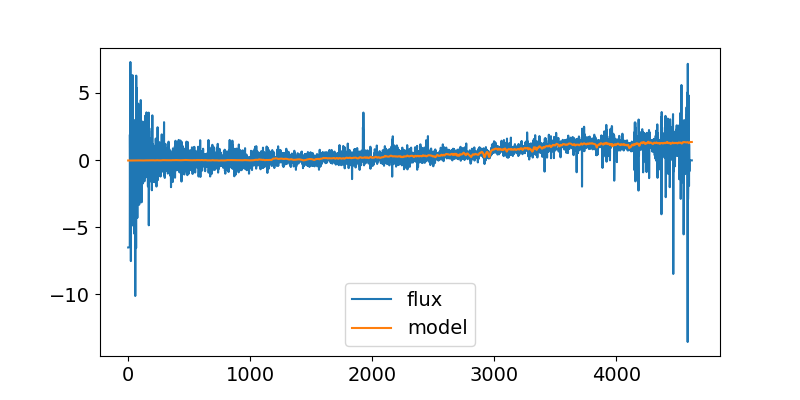

In [20]:
recs = results.records
fig=plt.figure(1, figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
fline, = plt.plot(recs[1].flux, label=f'flux')
mline, = plt.plot(recs[1].model, label=f'model')
plt.legend(handles=[fline,mline])

In [21]:
import sparcl.gather_2d
ar_dict, grid = sparcl.gather_2d.align_records(results.records)

## Plot full FLUX for all records

<Axes: xlabel='Wavelength', ylabel='Flux'>

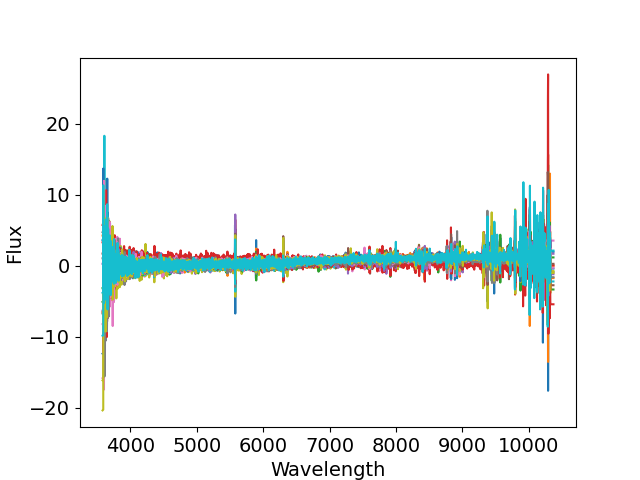

In [22]:
modeldf = pd.DataFrame(data=ar_dict['flux'],columns=grid)
modeldf.transpose().plot(xlabel='Wavelength', ylabel='Flux', legend=False)